In [1]:
%matplotlib inline
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import math

In [2]:
def fetch(url):
    import requests, gzip, os, hashlib

    cache_dir = os.path.join(os.getcwd(), ".cache")
    if not os.path.isdir(cache_dir):
        os.mkdir(cache_dir)

    fp = os.path.join(cache_dir, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8)

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28)).astype(np.float32) / 255
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28)).astype(np.float32) / 255
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import tensor

class SmolNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.log_softmax(self.l2(x), dim=1)
        return x


loss=0.05, acc=1.000000: 100%|██████████| 1000/1000 [00:01<00:00, 654.77it/s]


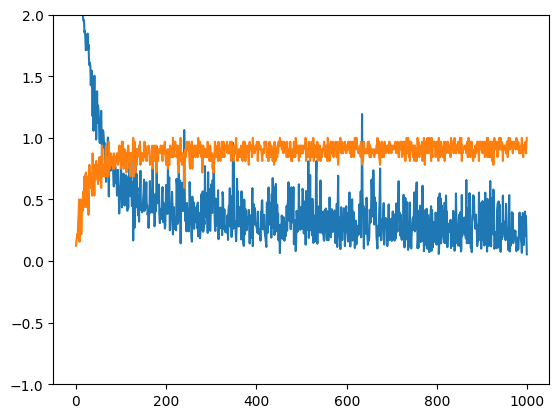

In [4]:
def torch_train(model):
    BATCH = 32
    loss_func = nn.NLLLoss()
    #optimizer = optim.Adam(model.parameters())
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    accuracies = []
    losses = []
    for i in (t := trange(1000)):
        # prepare data
        samp = np.random.randint(0, X_train.shape[0], size=(BATCH))
        X = tensor(X_train[samp], requires_grad=True).reshape((-1, 28*28))
        Y = tensor(Y_train[samp]).long()

        # train
        optimizer.zero_grad()
        out = model(X)
        pred = out.argmax(axis=1)
        acc = (pred == Y).float().mean()
        loss = F.nll_loss(out, Y)
        loss.backward()
        optimizer.step()

        # stat
        acc, loss = acc.item(), loss.item()
        accuracies.append(acc)
        losses.append(loss)
        t.set_description('loss={:.2f}, acc={:2f}'.format(loss, acc))

    return losses, accuracies

model = SmolNet()
losses, accuracies = torch_train(model)
plt.ylim(-1, 2)
plt.plot(losses)
plt.plot(accuracies)

In [5]:
def torch_eval():
    X = tensor(X_test).reshape((-1, 28*28))
    Y = tensor(Y_test)
    out = model(X)
    pred = out.argmax(axis=1)
    acc = (Y == pred).float().mean()
    return acc

torch_eval()

tensor(0.9217)

In [6]:
# copy model from pytorch to numpy
torch_l1 = np.zeros((28*28, 128), dtype=np.float32)
torch_l2 = np.zeros((128, 10), dtype=np.float32)
torch_l1[:] = model.l1.weight.detach().numpy().transpose()
torch_l2[:] = model.l2.weight.detach().numpy().transpose()

In [43]:
def log_softmax(x):
    x_max = x.max(axis=1)
    logexpsum = x_max + np.log(np.exp(x - x_max.reshape((-1, 1))).sum(axis=1))
    return x - logexpsum.reshape((-1, 1))
    #return x - np.log(np.exp(x).sum())

# smolgrad forward
def forward(x, l1, l2):
    x = x.dot(l1)
    x = np.maximum(0, x) # relu
    x = x.dot(l2)

    # log softmax
    x = log_softmax(x)
    #den = np.log(np.exp(x).sum())
    #x = np.log(np.exp(x)) - den

    return x

In [44]:
# now we have the same weights in numpy arrays
# we can test whether our forward pass works by checking on the accuarcy

def smol_eval(l1, l2):
    preds = forward(X_test.reshape((-1, 28*28)), l1, l2).argmax(axis=1)
    acc = (preds == Y_test).mean()
    return acc

smol_acc = smol_eval(torch_l1, torch_l2)
torch_acc = torch_eval().item()

if math.isclose(torch_acc, smol_acc, abs_tol=1e-4):
    print('accuracy matches!')

smol_acc, torch_acc

accuracy matches!


(0.9217, 0.9217000007629395)

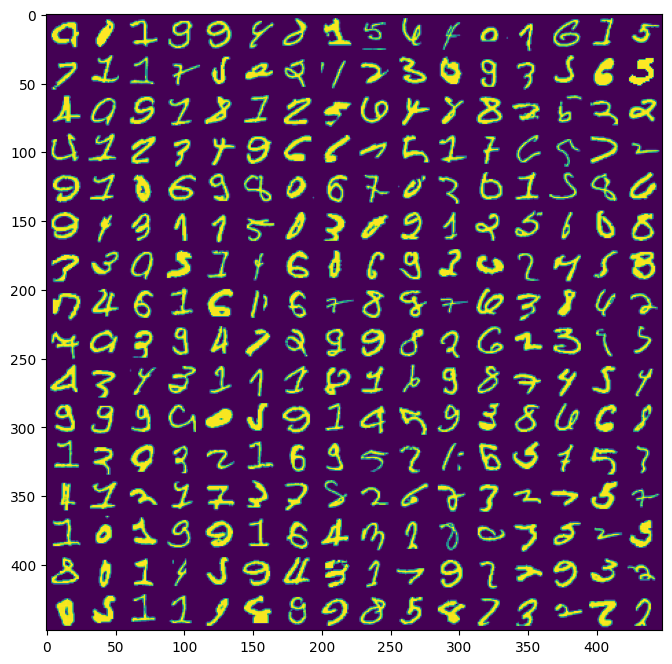

In [45]:
def smol_loss(X, Y):
    X = X.reshape((-1, 28*28))
    out = forward(X, torch_l1, torch_l2)
    pred = out.argmax(axis=1)
    loss = -out[range(out.shape[0]), Y]

    return loss

def show_cursed_digits(X, loss):
    G = 16
    messup = sorted(zip(loss, range(X.shape[0])), key=lambda x: x[0], reverse=True)
    X_bad = X[[x[1] for x in messup[:G*G]]]
    plt.figure(figsize=(8,8))
    imshow(np.concatenate(X_bad.reshape((G, 28 * G, 28)), axis=1))

show_cursed_digits(X_train, smol_loss(X_train, Y_train))

tensor(0.4652, grad_fn=<NllLossBackward0>)
loss.grad = tensor(1.)
x_lsm.grad = tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.5000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.5000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000]])
x_l2.grad = tensor([[ 7.9424e-04,  1.5171e-05,  2.9505e-03,  2.9610e-01,  3.2265e-07,
         -3.0270e-01,  7.3692e-06,  2.0651e-03,  5.9686e-04,  1.7033e-04],
        [-2.4134e-04,  2.2805e-09,  3.5145e-05,  1.8702e-05,  2.3343e-08,
          1.5837e-04,  7.6253e-07,  3.4899e-06,  2.2145e-05,  2.6542e-06]])


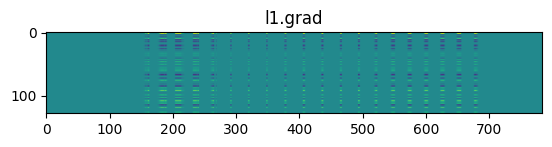

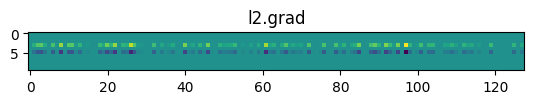

In [46]:
# backward, pytorch reference
def torch_backward():
    model.zero_grad()

    # forward
    x = tensor(X_train[0:2].reshape((-1, 28*28)))
    x_l1 = model.l1(x)
    x_relu = F.relu(x_l1)
    x_l2 = model.l2(x_relu)
    x_lsm = F.log_softmax(x_l2, dim=1)
    loss = F.nll_loss(x_lsm, tensor(Y_train[0:2]))
    print(loss)

    x_l1.retain_grad()
    x_relu.retain_grad()
    x_l2.retain_grad()
    x_lsm.retain_grad()
    loss.retain_grad()

    # backward
    loss.backward()

    print('loss.grad =', loss.grad)
    print('x_lsm.grad =', x_lsm.grad)
    print('x_l2.grad =', x_l2.grad)
    #print('x_relu.grad =', x_relu.grad)
    #print('x_l1.grad =', x_l1.grad)

    plt.figure()
    plt.title("l1.grad")
    imshow(model.l1.weight.grad)

    plt.figure()
    plt.title("l2.grad")
    imshow(model.l2.weight.grad)

torch_backward()

loss=0.418423, acc=0.875000: 100%|██████████| 1000/1000 [00:12<00:00, 82.62it/s]


0.9223

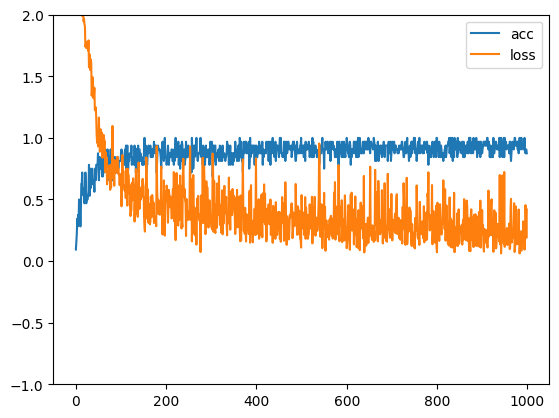

In [52]:
# backward, ours

def smol_train():

    # init weights
    torch_net = SmolNet()

    # borrow initialization from pytorch
    l1 = np.zeros(((28 * 28, 128)))
    l2 = np.zeros(((128, 10)))
    l1[:] = torch_net.l1.weight.detach().numpy().transpose()
    l2[:] = torch_net.l2.weight.detach().numpy().transpose()

    # l1[:] = torch_l1
    # l2[:] = torch_l2
    #l1 = np.random.rand(28 * 28, 128).astype(np.float32)
    #l2 = np.random.rand(128, 10).astype(np.float32)

    BATCH = 32
    lr = 0.1

    losses = []
    accuracies = []

    for i in (t := trange(1000)):
        # forward
        # prepaer data
        samp = np.random.randint(0, X_train.shape[0], size=(BATCH))
        X = X_train[samp]
        Y = Y_train[samp]

        x = X.reshape((-1, 28*28))
        x_l1 = x.dot(l1)
        x_relu = np.maximum(0, x_l1)
        x_l2 = x_relu.dot(l2) # W = trelu, x = l2, feels inverted...
        #print(l2)
        x_lsm = log_softmax(x_l2)
        loss = -x_lsm[range(x_lsm.shape[0]), Y] # nll, take label component and neagte
        #print('loss =', loss.mean())

        # compute the accuracy on batch, to plot an accurary graph
        pred = x_lsm.argmax(axis=1)
        acc = (pred == Y).astype(np.float32).mean()

        # backward

        # gradient of NLL, i.e. dL/dout
        dlsm = np.zeros(x_lsm.shape)
        dlsm[range(dlsm.shape[0]), Y] = -1.0 / BATCH
        #print(dlsm)

        # gradient of log softmax, i.e. dL/dxl2
        #print(dlsm.sum(axis=1))
        dx_l2 = dlsm - np.exp(x_lsm)*dlsm.sum(axis=1).reshape((-1, 1))

        # gradient of dot(l2), dL/drelu and dL/dl2
        # input dtl2 (1,10), trelu (1, 128)
        # output (128, 10)
        dl2 = x_relu.T.dot(dx_l2)
        #print(x_relu)

        # input dtl2 (1, 10), l2 (128,10)
        # output shape (1, 128)
        dx_relu = dx_l2.dot(l2.T)

        # gradient of relu, dL/dtl1 = dL/drelu * drelu/dtl1
        dx_l1 = dx_relu.copy()
        dx_l1[(x_l1 < 0.0)] = 0.0

        # gradient of dot(l1), dL/dx or dL/dl1, but we only want dL/dl1, because we already reached the starting point
        # dL/dl1 = dL/dtl1 * dtl1/dl1 = dL/dtl1 * x
        # input x (1,784), dtl1 (1, 128)
        # output (784, 128)
        dl1 = x.T.dot(dx_l1)

        # SGD
        l2 = l2 - lr * dl2
        l1 = l1 - lr * dl1

        # stat
        accuracies.append(acc)
        losses.append(loss.mean())
        t.set_description('loss={:2f}, acc={:2f}'.format(loss.mean(), acc))

        # plot grad for sanity check
        #plt.figure()
        #plt.title("dl1.grad")
        #imshow(dl1.T)
        #plt.figure()
        #plt.title("dl2.grad")
        #imshow(dl2.T)
        #print(dx_l2)

    plt.ylim(-1, 2)
    plt.plot(accuracies)
    plt.plot(losses)
    plt.legend(labels=['acc', 'loss'])

    return l1, l2

l1, l2 = smol_train()
smol_eval(l1, l2)